In [1]:
import os
import os.path as osp
import json
import pickle
import collections as C
import itertools as I
import random
import math
from typing import Dict, List, Union, Tuple, Optional

import numpy as np
from loguru import logger
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import make_interp_spline
import matplotlib.cm as cm

from common.constants import CORE_OPTIONS
from common.utils import remove_comments, normalize_spaces, remove_spaces
from common.pantograph.dataclasses import ProblemGenerationProcess

In [ ]:
def count_kc(d: ProblemGenerationProcess) -> int:
    try:
        if 'proving_results' in d.metainfo:
            return len(remove_spaces(remove_comments(d.formal_solution_draft)))
        else:
            return d.metainfo['eval_result']['KC']
    except:
        # return len(remove_spaces(remove_comments(d.formal_solution_draft)))
        return float('nan')

de 

NAME_MAPPING = {
    "autoformalization_pg_kimina7b-PromptCoT-DS_kimina7b-valid_samples.jsonl" : "PromptCoT-DS",
    "autoformalization_pg_kimina7b-PromptCoT-QwQ_kimina7b-valid_samples.jsonl" : "PromptCoT-QwQ",
    "autoformalization_pg_kimina7b-ScaleQuest-Math_kimina7b-valid_samples.jsonl" : "ScaleQuest-Math",
    "MUSTARDSauce_lean4_parsed-valid_samples.jsonl" : "MUSTARD",
    "MUSTARDSauce_lean4_parsed-nocomment-valid_samples.jsonl" : "MUSTARD (w/o comment)",
    "sft_ar_v3-Goedel-Prover-V2-8B.Numina-Lean-reasseblmed.39509.problem_generator.nopack.3epoch.0913.staged-valid_samples.jsonl" : "Ablation (Staged)",
    "sft_ar_v3-Goedel-Prover-V2-8B.Numina-Lean-reasseblmed.39509.problem_generator.nopack.3epoch-valid_samples.jsonl" : "Main",
    "sft_wg_starified-Goedel-Prover-V2-8B.Numina-Lean.whole_statement_generatior.nopack-valid_samples.jsonl" : "Ablation (WSG)"
}
sample_data = dict()

for p in os.listdir('/sfs/liuqi/data/fpg_valid_fixed_evaluated'):
    benchmark_name = NAME_MAPPING[p]
    with open(osp.join('/sfs/liuqi/data/fpg_valid_fixed_evaluated', p), 'r') as f:
        data = [json.loads(l) for l in f.readlines()]
    
    with open(osp.join('/sfs/liuqi/data/fpg_valid_formal', p), 'r') as f:
        data_formal = [json.loads(l) for l in f.readlines()]
    
    assert len(data) == len(data_formal)
    for (d_i, d_f) in zip(data, data_formal):
        for k in ['header', 'formal_statement', 'formal_proof', 'condition', 'index', 'src']:
            assert d_i[k] == d_f[k]
    
    # sample_data = [(d_f['kc'], 0, True) if d['informalization']['problem_type'] == "Proof Question" else (
    #         d_f['kc'],
    #         len(d['informalization']['eval_results']['succeeded'])/(len(d['informalization']['eval_results']['succeeded'])+len(d['informalization']['eval_results']['failed'])),
    #         False
    #     )
    #     for (d, d_f) in zip(data, data_formal)]
    
    print(benchmark_name, len(data))
    results = []
    for (d, d_f) in zip(data, data_formal):
        if d['informalization']['problem_type'] == "Proof Question" or d['informalization']['informal_answer_parsed'] is None:
            results.append((d_f['kc'], 0, True))
        else:
            assert len(d['informalization']['eval_results']['succeeded'])+len(d['informalization']['eval_results']['failed']) == 6
            results.append((
                d_f['kc'],
                1 - len(d['informalization']['eval_results']['succeeded'])/6,
                False
            ))
    sample_data[benchmark_name] = results

PromptCoT-QwQ 1024
MUSTARD (w/o comment) 3791
Main 2726
MUSTARD 3791
Ablation (WSG) 1164
Ablation (Staged) 2340
PromptCoT-DS 457
ScaleQuest-Math 2035


In [ ]:
results_by_benchmark_by_model = dict()

for p in os.listdir('/sfs/liuqi/data/fpg_valid_fixed_evaluated'):
    benchmark_name = NAME_MAPPING[p]
    with open(osp.join('/sfs/liuqi/data/fpg_valid_fixed_evaluated', p), 'r') as f:
        data = [json.loads(l) for l in f.readlines()]
    
    with open(osp.join('/sfs/liuqi/data/fpg_valid_formal', p), 'r') as f:
        data_formal = [json.loads(l) for l in f.readlines()]
    
    assert len(data) == len(data_formal)
    for (d_i, d_f) in zip(data, data_formal):
        for k in ['header', 'formal_statement', 'formal_proof', 'condition', 'index', 'src']:
            assert d_i[k] == d_f[k]
    # sample_data = [(d_f['kc'], 0, True) if d['informalization']['problem_type'] == "Proof Question" else (
    #         d_f['kc'],
    #         len(d['informalization']['eval_results']['succeeded'])/(len(d['informalization']['eval_results']['succeeded'])+len(d['informalization']['eval_results']['failed'])),
    #         False
    #     )
    #     for (d, d_f) in zip(data, data_formal)]

    results_by_model = C.defaultdict(list)
    data_by_difficulty = sorted([
        (d, d_f, len(d['informalization']['eval_results']['succeeded'])/6) for d, d_f in zip(data, data_formal) if (d['informalization']['problem_type'] == "Problem-Solving Question" and d['informalization']['informal_answer_parsed'] is not None)
    ], key=lambda x : x[-1])

    for (d, d_f, _) in data_by_difficulty:
        for m in d['informalization']['eval_results']['succeeded']:
            results_by_model[m].append(True)
        for m in d['informalization']['eval_results']['failed']:
            results_by_model[m].append(False)
    results_by_benchmark_by_model[benchmark_name] = results_by_model
        

    results_by_model = C.defaultdict(list)

    data_top500 = data_by_difficulty[:500]
    for (d, d_f, _) in data_top500:
        for m in d['informalization']['eval_results']['succeeded']:
            results_by_model[m].append(True)
        for m in d['informalization']['eval_results']['failed']:
            results_by_model[m].append(False)
    results_by_benchmark_by_model[benchmark_name+'.Top500'] = results_by_model

In [ ]:
d['informalization']['eval_results']['succeeded'], d['informalization']['eval_results']['failed']dd

([],
 ['Llama-3.2-3B-Instruct',
  'OLMo-2-1124-7B-Instruct',
  'Phi-4-mini-instruct',
  'Mistral-7B-Instruct-v0.3',
  'Meta-Llama-3.1-8B-Instruct',
  'Qwen3-8B'])

In [9]:
for (k, vs) in sample_data.items():
    print(k, len([v for v in vs if v[-1] == False]))

PromptCoT-QwQ 683
MUSTARD (w/o comment) 2765
Main 1326
MUSTARD 2744
Ablation (WSG) 504
Ablation (Staged) 1093
PromptCoT-DS 224
ScaleQuest-Math 1886


In [4]:
difficulty_data = C.defaultdict(list)

for (k, vs) in sample_data.items():
    for v in vs:
        if v[-1] is False:
            difficulty_data[k].append(1 - v[1])

In [5]:
for k, vs in difficulty_data.items():
    vs.sort()
    print(k, len(vs), np.mean(vs[:200]), np.mean(vs[:500]), np.mean(vs), sep='\t')

PromptCoT-QwQ	683	0.07166666666666664	0.30399999999999994	0.4458272327964861
MUSTARD (w/o comment)	2765	0.0	0.12499999999999997	0.7971669680530441
Main	1326	0.0	0.051	0.471342383107089
MUSTARD	2744	0.0	0.15566666666666662	0.8011418853255586
Ablation (WSG)	504	0.09749999999999996	0.514	0.5178571428571429
Ablation (Staged)	1093	0.0	0.09266666666666666	0.4730100640439158
PromptCoT-DS	224	0.34333333333333327	0.4032738095238094	0.4032738095238094
ScaleQuest-Math	1886	0.0008333333333333332	0.28	0.7556557087310004


In [3]:
# import math

# plt.figure(figsize=(10, 6))  # 设置图表大小（宽10英寸，高6英寸）
# degree = 1

# # 定义颜色和标记（区分不同实验，可扩展）
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 'cyan', 'yellow']
# markers = ['o', 's', '^', 'D', 'v', '<']  # 圆形、方形、三角形等标记

# # --------------------------
# # 2. 遍历数据并绘制每个实验
# # --------------------------
# for idx, (benchmark_name, results) in enumerate(sample_data.items()):
#     # if benchmark_name != 'Main':
#         # continue
#     # 提取当前实验的 x 轴和 y 轴数据（从 Tuple 列表中拆分）
#     x_data = [math.log2(coord[0]) for coord in results if coord[0] != float('inf')]
#     y_data = [coord[1] for coord in results if coord[0] != float('inf')]

#     # 绘制曲线：颜色和标记循环使用，避免索引超出
#     color = colors[idx % len(colors)]
#     marker = markers[idx % len(markers)]
    
#     plt.scatter(
#         x_data, y_data,
#         label=benchmark_name,
#         color=color,
#         marker='.',
#         s=100,  # 点的大小
#         alpha=0.7,  # 透明度，便于查看重叠点
#         edgecolors='w',  # 白色边框，增强可读性
#         linewidth=1.5  # 边框宽度
#     )
#     coefficients = np.polyfit(x_data, y_data, degree)
#     polynomial = np.poly1d(coefficients)
    
#     # 生成用于绘制拟合线的x值（更密集，使线条平滑）
#     x_fit = np.linspace(min(x_data), max(x_data), 100)
#     y_fit = polynomial(x_fit)
    
#     # 绘制拟合线
#     plt.plot(
#         x_fit, y_fit,
#         color=color,
#         linestyle='--',  # 虚线表示拟合线
#         linewidth=2,
#         alpha=0.8
#     )

# # --------------------------
# # 3. 美化图表与添加标注
# # --------------------------
# plt.xlabel('Complexity', fontsize=12, fontweight='bold')
# plt.ylabel('Difficulty', fontsize=12, fontweight='bold')
# plt.title('Correlation', fontsize=14, fontweight='bold', pad=20)

# # 添加图例（自动识别每个实验的 label）
# plt.legend(
#     loc='best',  # 自动选择最佳位置（避免遮挡数据）
#     fontsize=10,
#     frameon=True,  # 显示图例边框
#     shadow=True    # 增加阴影提升质感
# )

# # 添加网格（辅助读取数据）
# plt.grid(True, alpha=0.3, linestyle='--')

# # plt.xscale('log')

# # 调整布局（防止标签被截断）
# plt.tight_layout()

# # 显示图表（运行时会弹出窗口）
# plt.show()


In [4]:
def visualize_data(data: Dict[str, List[Tuple[float, float, bool]]], 
                   figsize: Tuple[int, int] = (12, 8),
                   dpi: int = 100) -> None:
    """
    可视化实验数据，展示不同复杂度区间内各实验的结果数量及难度分布
    低难度（0）显示为绿色，高难度（1）显示为红色
    不同实验使用不同纹理图案区分，重采样样本(is_not_evaluated_problem=True)显示为白色
    """
    # 定义复杂度区间
    # bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, float('inf')]
    bins = [0, 300, 600, 900, float('inf')]
    bin_labels = [
        '0~300', '300~600', '600~900', '900+', r'$\infty$'
    ]
    num_bins = len(bin_labels)
    
    # 获取所有实验名称
    exp_names = [
        "Main", "Ablation (Staged)", "Ablation (WSG)", "PromptCoT-DS", "PromptCoT-QwQ", "ScaleQuest-Math", "MUSTARD",
        # "MUSTARD (w/o comment)",
    ]
    num_experiments = len(exp_names)
    
    # 定义实验的纹理图案和对应颜色
    hatches = ['', '..', '//', '\\\\', 'xx', '++', '--', '*']
    hatch_colors = ['black'] * len(hatches)  # 纹理统一使用黑色
    
    # 调整图案数量以匹配实验数量
    if num_experiments > len(hatches):
        hatches = [hatches[i % len(hatches)] for i in range(num_experiments)]
        hatch_colors = [hatch_colors[i % len(hatch_colors)] for i in range(num_experiments)]
    else:
        hatches = hatches[:num_experiments]
        hatch_colors = hatch_colors[:num_experiments]
    
    # 为每个实验和每个区间准备数据
    # 总计数（包括重采样样本）
    total_counts = {exp: [0]*num_bins for exp in exp_names}
    # 正常样本的难度（不包括重采样样本）
    normal_difficulties = {exp: [[] for _ in range(num_bins)] for exp in exp_names}
    # 重采样样本的计数
    not_evaluated_problem_counts = {exp: [0]*num_bins for exp in exp_names}
    
    # 填充数据
    for exp in exp_names:
        delta = (1/28316*100) if 'mustard' in exp.lower() else (1/5000*100)
        results = data[exp]
        for complexity, difficulty, is_not_evaluated_problem in results:
            # 确保难度值在[0,1]范围内（仅对非重采样样本有效）
            difficulty = max(0, min(1, difficulty))
            
            # 确定属于哪个复杂度区间
            for bin_idx in range(num_bins):
                if bin_idx < num_bins - 1:
                    if bins[bin_idx] <= complexity < bins[bin_idx+1]:
                        total_counts[exp][bin_idx] += delta
                        if is_not_evaluated_problem:
                            not_evaluated_problem_counts[exp][bin_idx] += delta
                        else:
                            normal_difficulties[exp][bin_idx].append(difficulty)
                        break
                else:  # 最后一个区间是inf
                    total_counts[exp][bin_idx] += delta
                    if is_not_evaluated_problem:
                        not_evaluated_problem_counts[exp][bin_idx] += delta
                    else:
                        normal_difficulties[exp][bin_idx].append(difficulty)
                    break
    
    # 计算最大计数用于设置y轴范围
    max_count = max(max(exp_counts) for exp_counts in total_counts.values())
    # max_count = 1
    
    # 设置柱状图的宽度和间距
    bar_width = 0.8 / num_experiments
    x = np.arange(num_bins)
    
    # 创建图表
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    
    # 创建绿色到红色的颜色映射（用于非重采样样本）
    colors = [(0, 1, 0), (1, 1, 0), (1, 0, 0)]  # 绿->黄->红
    cmap = LinearSegmentedColormap.from_list('difficulty_cmap', colors, N=100)
    
    # 为每个实验绘制柱子
    for i, exp in enumerate(exp_names):
        delta = (1/28316*100) if 'mustard' in exp.lower() else (1/5000*100)
        bar_x = x - 0.4 + bar_width/2 + i * bar_width
        hatch = hatches[i]
        h_color = hatch_colors[i]
        
        for bin_idx in range(num_bins):
            total_count = total_counts[exp][bin_idx]
            if total_count == 0:
                continue  # 跳过没有数据的区间
            
            # 获取正常样本和重采样样本数量
            normal_count = total_count - not_evaluated_problem_counts[exp][bin_idx]
            resample_count = not_evaluated_problem_counts[exp][bin_idx]
            
            # 1. 绘制正常样本部分（按难度分布）
            current_bottom = 0

            # 2. 绘制重采样样本部分（白色，不参与难度分布）
            if resample_count > 0:
                ax.bar(
                    bar_x[bin_idx], resample_count, bottom=current_bottom, width=bar_width*0.9,
                    color='white',  # 重采样样本显示为白色
                    edgecolor='darkgray',
                    linewidth=0.3,
                    hatch=hatch,
                    alpha=0.9
                )
                current_bottom += resample_count

            if normal_count > 0:
                diffs = normal_difficulties[exp][bin_idx]
                # 将[0,1]区间分成20个小间隔
                heatmap_bins = np.linspace(0, 1, 21)
                # 计算每个难度区间的样本数量
                diff_counts, _ = np.histogram(diffs, bins=heatmap_bins)
                
                for h_idx in range(len(diff_counts)):
                    segment_height = diff_counts[h_idx] * delta
                    if segment_height == 0:
                        continue
                    
                    # 难度值取区间中点作为颜色映射依据
                    difficulty_value = (heatmap_bins[h_idx] + heatmap_bins[h_idx+1]) / 2
                    
                    ax.bar(
                        bar_x[bin_idx], segment_height, bottom=current_bottom, width=bar_width*0.9,
                        color=cmap(difficulty_value),
                        edgecolor='darkgray',
                        linewidth=0.3,
                        hatch=hatch,
                        alpha=0.9
                    )
                    
                    current_bottom += segment_height
            

    
    # 设置图表属性
    ax.set_xlabel('Complexity Range', fontsize=12)
    ax.set_ylabel('Valid Generation %', fontsize=12)
    ax.set_title('Distribution of Generation Results by Complexity and Difficulty', fontsize=14, pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(bin_labels, rotation=45, ha='right', fontsize=10)
    ax.set_ylim(0, max_count * 1.1)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 添加颜色条（仅表示正常样本的难度）
    cbar = plt.colorbar(cm.ScalarMappable(cmap=cmap), ax=ax)
    cbar.set_label('Difficulty (0=Low, 1=High)', rotation=270, labelpad=20)
    
    # 添加图例
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=cmap(0.5), 
                                    edgecolor='darkgray', hatch=hatches[i],) 
                      for i, _ in enumerate(exp_names)]
    # 添加重采样样本的图例说明
    legend_elements.append(plt.Rectangle((0,0),1,1, facecolor='white', 
                                        edgecolor='darkgray', hatch='',))
    exp_names_with_resample = exp_names + ['Not Evaluated']
    ax.legend(legend_elements, exp_names_with_resample, loc='upper right', title='Experiments')
    
    plt.tight_layout()
    plt.show()

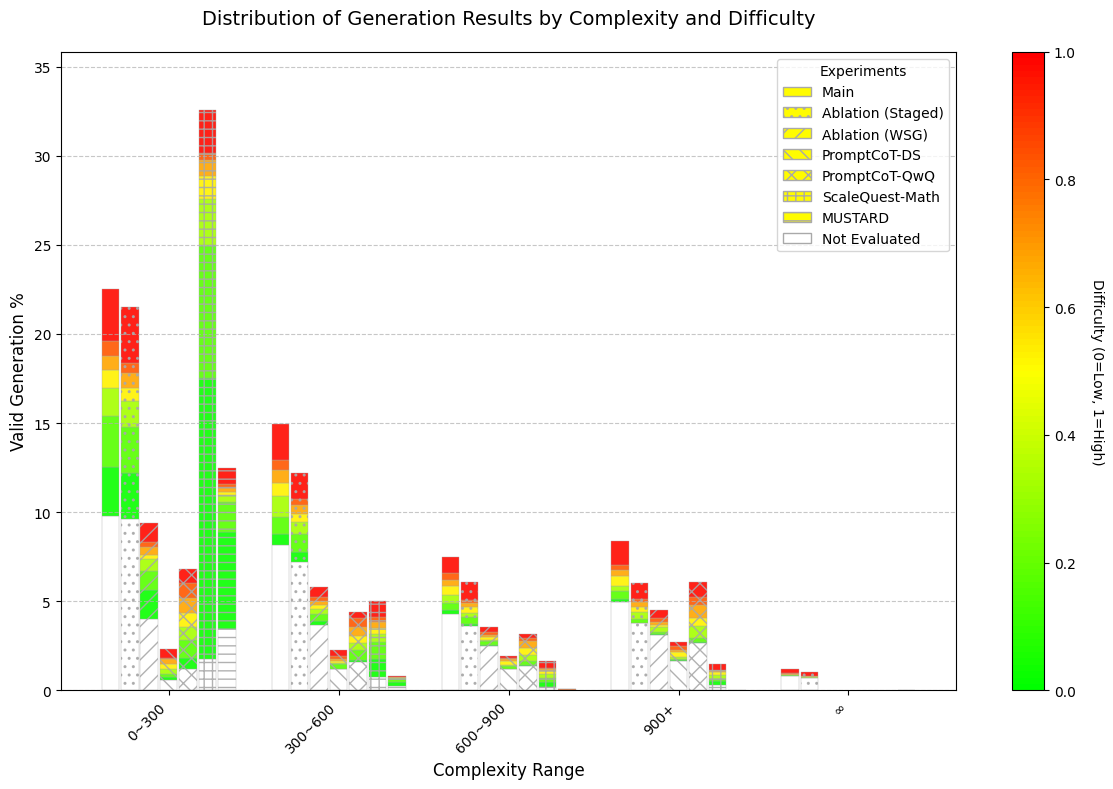

In [5]:
# np.random.seed(42)

# def generate_sample_data(num_samples: int, resample_ratio: float = 0.2) -> List[Tuple[float, float, bool]]:
#     complexities = []
#     # 大部分数据分布在0~1000
#     complexities.extend(np.random.uniform(0, 1000, int(num_samples * 0.9)))
#     # 一些1000+的数据
#     complexities.extend(np.random.uniform(1000, 1500, int(num_samples * 0.08)))
#     # 少量inf数据
#     complexities.extend([float('inf')] * int(num_samples * 0.02))
    
#     # 难度在[0,1]之间
#     difficulties = np.random.beta(2, 2, num_samples)
    
#     # 随机生成重采样标记
#     is_not_evaluated_problem = np.random.choice([True, False], size=num_samples, p=[resample_ratio, 1-resample_ratio])
    
#     return list(zip(complexities, difficulties, is_not_evaluated_problem))

# sample_data = {
#     "Experiment A": generate_sample_data(500),
#     "Experiment B": generate_sample_data(700),
#     "Experiment C": generate_sample_data(600)
# }

visualize_data(sample_data)